Analysis of results
====
This notebook reads the results obtained in Part 1 to calculate diverse metrics of similitude 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel
from glob import glob
import pandas as pd
import os
from pprint import pprint
from skimage.measure import label, regionprops, regionprops_table

In [2]:
#uncomment this to install itables for nice pandas table display and openpyxl to export to Excel
#!pip install itables openpyxl


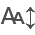

In [3]:
import itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)


## Metrics 
The code below is used to compare Rayleigh+FDTD and Rayleigh alone in terms of peak pressure, L2-norm L-inf, focal spot location, and focal spot dimensions.

In [80]:
def CalcVolumetricMetrics(Data,voxelsize):
    DataN=Data/Data.max()
    label_img=label(DataN>=0.5)
    props = regionprops(label_img)#, properties=('centroid',   'area', 'moments_central','axis_major_length','axis_minor_length'))
    Res={}
    if len(props)>1:
        Volumes=[]
        for p in props:
            Volumes.append(p['area'])  
        p=props[np.argmax(Volumes)]
    else:
        p=props[0]
    Res['centroid']=p['centroid']*voxelsize
    Res['volume']=p['area']*np.prod(voxelsize)
    Axes=ellipsoid_axis_lengths(p['moments_central'])
    Res['long_axis']=Axes[0]*voxelsize[0]
    Res['minor_axis_1']=Axes[1]*voxelsize[1]
    Res['minor_axis_2']=Axes[2]*voxelsize[2]
    # print(Res)
    return Res

def ellipsoid_axis_lengths(central_moments):
    """Compute ellipsoid major, intermediate and minor axis length.

    Parameters
    ----------
    central_moments : ndarray
        Array of central moments as given by ``moments_central`` with order 2.

    Returns
    -------
    axis_lengths: tuple of float
        The ellipsoid axis lengths in descending order.
    """
    m0 = central_moments[0, 0, 0]
    sxx = central_moments[2, 0, 0] / m0
    syy = central_moments[0, 2, 0] / m0
    szz = central_moments[0, 0, 2] / m0
    sxy = central_moments[1, 1, 0] / m0
    sxz = central_moments[1, 0, 1] / m0
    syz = central_moments[0, 1, 1] / m0
    S = np.asarray([[sxx, sxy, sxz], [sxy, syy, syz], [sxz, syz, szz]])
    # determine eigenvalues in descending order
    eigvals = np.sort(np.linalg.eigvalsh(S))[::-1]
    return tuple([np.sqrt(20.0 * e) for e in eigvals])    

def qcheck(InA,InB,bPlot=False):
    A=nibabel.load(InA)
    B=nibabel.load(InB)
    AData=np.flip(A.get_fdata(),axis=2)
    BData=np.flip(B.get_fdata(),axis=2)
    #the layer where the source was placed should not be considered for comparison
    # in cases where the Tx is moved "into" the skin, there will be a few layers with 0 values, 
    # the source is always placed in the first non-zero layer
    CenterLine=AData[AData.shape[0]//2,AData.shape[1]//2,:]
    nonzero=np.array(np.where(CenterLine!=0.0)).flatten()
    AData=AData[:,:,nonzero[0]+1:]
    BData=BData[:,:,nonzero[0]+1:]
        
    VolA=CalcVolumetricMetrics(AData,np.array(A.header.get_zooms()))
    VolB=CalcVolumetricMetrics(BData,np.array(B.header.get_zooms()))

    LocMaxA=np.array(np.where(AData==AData.max())).flatten()*np.array(A.header.get_zooms())
    LocMaxB=np.array(np.where(BData==BData.max())).flatten()*np.array(B.header.get_zooms())

    
    Metrics={}
    Metrics['Distance focal centroid']=np.linalg.norm(VolA['centroid']-VolB['centroid'])
    Metrics['Distance focal max']=np.linalg.norm(LocMaxA-LocMaxB)
    Metrics['Difference amplitude'] = 100 * (AData.max() - BData.max()) / BData.max()
    Metrics['Difference volume'] = 100 * (VolA['volume'] -VolB['volume']) /VolB['volume']
    Metrics['Difference acoustic long axis'] = 100 * (VolA['long_axis'] - VolB['long_axis']) / VolB['long_axis']
    Metrics['Difference acoustic width 1'] = 100 * (VolA['minor_axis_1'] - VolB['minor_axis_1']) / VolB['minor_axis_1']
    Metrics['Difference acoustic width 2'] = 100 * (VolA['minor_axis_2'] - VolB['minor_axis_2']) / VolB['minor_axis_2']
    LInf=100.0 * np.abs(AData - BData) / BData.max()
    Metrics['L Inf']= LInf.max()
    Metrics['L Inf location']=np.array(np.where(LInf==Metrics['L Inf'])).flatten().tolist()
    Metrics['L2']= 100.0 * np.sqrt(np.sum((AData - BData)**2) / np.sum(BData**2) )    
    
    if bPlot:
        VoxA=A.header.get_zooms()
        VoxB=B.header.get_zooms()

        VoxA=A.header.get_zooms()
        Zvec=VoxA[2]*np.arange(AData.shape[2])
        LocMaxA=np.array(np.where(AData==AData.max())).flatten()
        Inorm=20*np.log10(AData/AData.max())
        
        Zvec2=np.linspace(Zvec[0],Zvec[-1],len(Zvec)*20)
        
        AcAxis=np.interp(Zvec2,Zvec,Inorm[LocMaxA[0],LocMaxA[1],:])
        Zvec=Zvec2
        distance6dB = Zvec[AcAxis>=-6];
        length6dB = distance6dB[-1]-distance6dB[0]
        MaxLoc=np.argmax(AcAxis)
        print('Length 6dB  in mm, limits and peak location=%4.3f,%4.3f,%4.3f,%4.3f\n' %(
            length6dB, distance6dB[0],distance6dB[-1],Zvec[MaxLoc]))
        
        LocMaxA=np.array(np.where(AData==AData.max())).flatten()
        LocMaxB=np.array(np.where(BData==BData.max())).flatten()
        
        plt.figure(figsize=(16,4))
        plt.subplot(1,4,1)
        plt.imshow(AData[LocMaxA[0],:,:].T,cmap=plt.cm.gray)
        plt.colorbar()
        plt.title('FDTD - YZ')
        plt.subplot(1,4,2)
        plt.imshow(BData[LocMaxB[0],:,:].T,cmap=plt.cm.gray)
        plt.colorbar()
        plt.title('Rayleigh - YZ')
        plt.subplot(1,4,3)
        plt.imshow(AData[:,LocMaxA[1],:].T,cmap=plt.cm.gray)
        plt.colorbar()
        plt.title('FDTD - XZ')
        plt.subplot(1,4,4)
        plt.title('Rayleigh - XZ')
        plt.imshow(BData[:,LocMaxB[1],:].T,cmap=plt.cm.gray)
        plt.colorbar()
        plt.suptitle('Comparison in plane at maximum peak pressure Rayleigh')
        
        plt.figure(figsize=(8,2))
        AcN1=AData[LocMaxA[0],LocMaxA[1],:]
        AcN2=BData[LocMaxB[0],LocMaxB[1],:]
        Za = VoxA[2]*np.arange(len(AcN1))
        Zb = VoxB[2]*np.arange(len(AcN2))
        plt.plot(Za,AcN1,)
        plt.plot(Zb,AcN2)
        plt.title('Z axis crossing max peak')
        plt.legend(['FDTD','Rayleigh'])

        plt.figure(figsize=(16,4))
        plt.subplot(1,4,1)
        plt.imshow(AData[Metrics['L Inf location'][0],:,:].T,cmap=plt.cm.gray)
        plt.plot(Metrics['L Inf location'][1],
                 Metrics['L Inf location'][2],'+y',markersize=18)
        plt.colorbar()
        plt.title('FDTD - YZ')
        plt.subplot(1,4,2)
        plt.imshow(BData[Metrics['L Inf location'][0],:,:].T,cmap=plt.cm.gray)
        plt.plot(Metrics['L Inf location'][1],
                 Metrics['L Inf location'][2],'+y',markersize=18)
        plt.colorbar()
        plt.title('Rayleigh - YZ')
        plt.subplot(1,4,3)
        plt.imshow(AData[:,Metrics['L Inf location'][1],:].T,cmap=plt.cm.gray)
        plt.plot(Metrics['L Inf location'][0],
                 Metrics['L Inf location'][2],'+y',markersize=18)
        plt.colorbar()
        plt.title('FDTD - XZ')
        plt.subplot(1,4,4)
        plt.title('Rayleigh - XZ')
        plt.imshow(BData[:,Metrics['L Inf location'][1],:].T,cmap=plt.cm.gray)
        plt.plot(Metrics['L Inf location'][0],
                 Metrics['L Inf location'][2],'+y',markersize=18)
        plt.colorbar()
        plt.suptitle('Comparison in plane at maximum L Inf (marker by +)')

        plt.figure(figsize=(8,2))
        AcN1=AData[Metrics['L Inf location'][0],Metrics['L Inf location'][1],:]
        AcN2=BData[Metrics['L Inf location'][0],Metrics['L Inf location'][1],:]
        Za = VoxA[2]*np.arange(len(AcN1))
        Zb = VoxB[2]*np.arange(len(AcN2))
        plt.plot(Za,AcN1)
        plt.plot(Zb,AcN2)
        plt.title('Z axis crossing max L inf (marked by vertical dotted line)')
        plt.plot([Za[Metrics['L Inf location'][2]],Za[Metrics['L Inf location'][2]]],
                 [np.min([AcN1.min(),AcN2.min()]),np.max([AcN1.max(),AcN2.max()])/2],':')
        plt.legend(['FDTD','Rayleigh'])
    
    
    return Metrics
    
    

## Processing all cases
The code below just process all cases and store the results in a Pandas table and exports it in a Excel spreadsheet

In [67]:
BasePath='/Users/spichardo/Library/CloudStorage/OneDrive-UniversityofCalgary/GDrive/ReplaceWaterBabel/SDR0p55/Cases/'

for case in range(0,500):
    print('Case %03i' %case,end='\r')
    fbase =BasePath + 'CASE_%04i_' % case
    fnames=glob(fbase+'*')
    if len(fnames)==0:
        break
    assert(len(fnames)==2)
    if '_FDTD_' in fnames[0]:
        FDTDFile=fnames[0]
        RayleighName=fnames[1]
    else:
        FDTDFile=fnames[1]
        RayleighName=fnames[0]
    Res={'case':case,'Description':FDTDFile.split('_FDTD_')[1]} | qcheck(FDTDFile,RayleighName)
    if case == 0:
        df=pd.DataFrame.from_dict(Res,orient='index').T
    else:
        df = pd.concat([df,pd.DataFrame.from_dict(Res,orient='index').T])


In [68]:
df['case'] = df['case'].astype(int)
df.set_index('case')
df.to_excel('SummaryAnalysis.xlsx',index=False)


Show the table of results

In [69]:
df

case                                        Description  \
0      0  ZAdj_-10.0_DEEP_Single_250kHz_6PPW_Foc50.0_Dia...   
0      1  ZAdj_-10.0_DEEP_Single_250kHz_6PPW_Foc60.0_Dia...   
0      2  ZAdj_-10.0_DEEP_Single_250kHz_6PPW_Foc70.0_Dia...   
0      3  ZAdj_-10.0_DEEP_Single_250kHz_6PPW_Foc50.0_Dia...   
0      4  ZAdj_-10.0_DEEP_Single_250kHz_6PPW_Foc60.0_Dia...   
..   ...                                                ...   
0    304  DEEP_REMOPD_250kHz_9PPW_XSteer_20.0_YSteer_10....   
0    305  DEEP_REMOPD_250kHz_9PPW_XSteer_20.0_YSteer_10....   
0    306  DEEP_REMOPD_250kHz_9PPW_XSteer_20.0_YSteer_20....   
0    307  DEEP_REMOPD_250kHz_9PPW_XSteer_20.0_YSteer_20....   
0    308  DEEP_REMOPD_250kHz_9PPW_XSteer_20.0_YSteer_20....   

   Distance focal centroid Distance focal max Difference amplitude  \
0                 1.148935            0.73499             2.203179   
0                 1.251543            0.73499             2.505397   
0                 1.488559                0.0             2.534278   
0                 0.269453                0.0             1.800563   
0                 0.499478            0.73499             1.740044   
..                     ...                ...                  ...   
0                 0.036514                0.0             0.202613   
0                 0.025077                0.0             0.199503   
0                 0.237004            0.48999             0.142586   
0                 0.167512            0.48999             0.153949   
0                 0.186214                0.0             0.233723   

   Difference volume Difference acoustic long axis  \
0         -12.921508                     -6.621296   
0          -9.290954                     -6.609547   
0          -9.846807                     -5.627713   
0          -6.681922                     -4.882168   
0          -6.496786                     -4.260372   
..               ...                           ...   
0          -1.030179                     -0.596676   
0          -0.883261                     -0.343116   
0          -0.540938                     -0.373344   
0          -0.555224                     -0.132599   
0          -0.593046                       0.11872   

   Difference acoustic width 1 Difference acoustic width 2     L Inf  \
0                    -3.288295                   -3.341386  5.074125   
0                    -1.421684                   -1.450801  3.951731   
0                    -2.352194                   -2.244348  5.106515   
0                    -0.829665                   -0.829665  4.420589   
0                    -1.125995                   -1.125995  3.963502   
..                         ...                         ...       ...   
0                    -0.295849                   -0.138371  3.717966   
0                    -0.459456                   -0.092466  3.966225   
0                     0.097401                    -0.22653  3.255489   
0                    -0.195797                   -0.222236   3.81957   
0                    -0.396658                   -0.356967   4.09066   

   L Inf location        L2  
0    [28, 28, 12]  7.220545  
0     [30, 30, 0]  4.196668  
0     [31, 31, 0]  3.615636  
0    [33, 33, 14]  5.667527  
0     [36, 36, 1]  3.816328  
..            ...       ...  
0     [82, 74, 2]  1.933916  
0     [78, 72, 6]   1.48853  
0     [88, 88, 9]  2.878219  
0     [82, 80, 0]  2.031053  
0     [78, 78, 5]   1.58526  

[309 rows x 12 columns]

## Illustrative cases
Based on the table above, we compare a few cases with plots showing the largest L inf deviation, which is the most 

CASE_0050_FDTD_ZAdj_10.0_DEEP_Single_250kHz_9PPW_Foc70.0_Diam60.0.nii.gz
Length 6dB  in mm, limits and peak location=60.790,35.048,95.838,51.949



{'Distance focal centroid': 0.07171155953304205,
 'Distance focal max': 0.0,
 'Difference amplitude': -0.01919722912984637,
 'Difference volume': -0.42666237320882305,
 'Difference acoustic long axis': -0.2956914018711844,
 'Difference acoustic width 1': -0.01967291014111433,
 'Difference acoustic width 2': -0.11472477098837286,
 'L Inf': 18.695567081620084,
 'L Inf location': [120, 35, 0],
 'L2': 1.40635628730161}

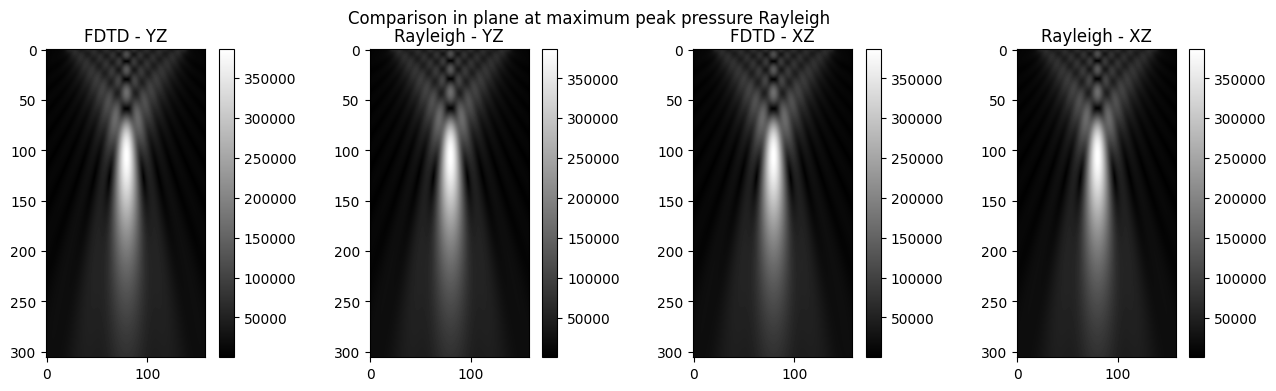

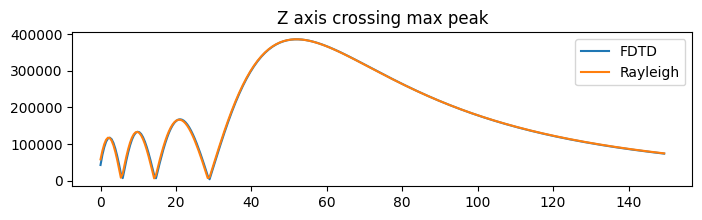

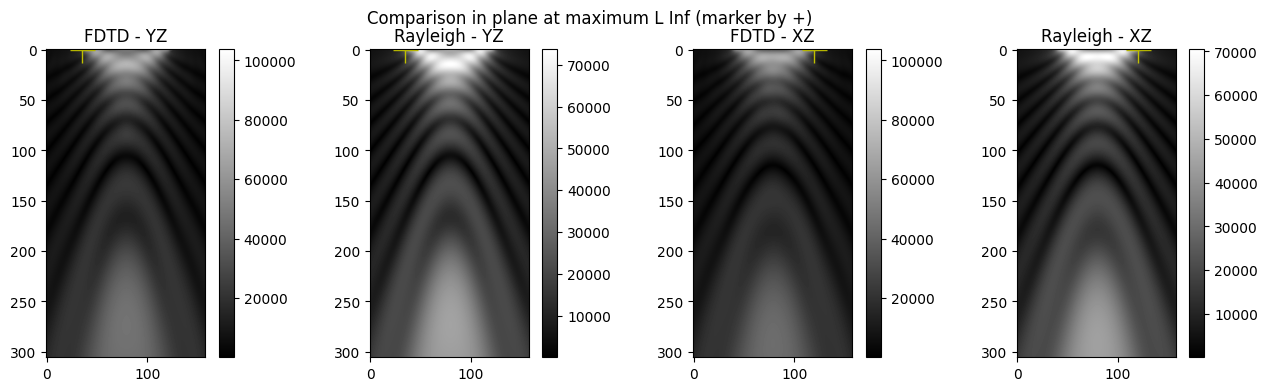

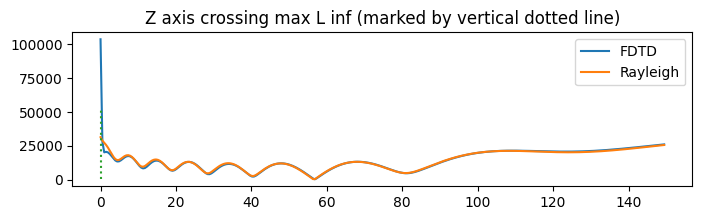

In [81]:
BasePath='/Users/spichardo/Library/CloudStorage/OneDrive-UniversityofCalgary/GDrive/ReplaceWaterBabel/SDR0p55/Cases/'
CASE=50;FDTD=glob(BasePath+'CASE_%04i_FDTD*' % CASE )[0];Ray=glob(BasePath+'CASE_%04i_Rayleigh*' % CASE)[0]
print(os.path.basename(FDTD))
qcheck(FDTD,Ray,bPlot=True)

In the previous, case we noticed that layer immediate below the source still shows occassionally a bit of deviation, but nothing ensuring to be critical.

CASE_0225_FDTD_ConeDistance_30.0_DEEP_H317_750kHz_6PPW_XSteer_0.0_YSteer_0.0_ZSteer_0.0.nii.gz
Length 6dB  in mm, limits and peak location=14.599,23.353,37.952,30.139



{'Distance focal centroid': 1.0046593729117501,
 'Distance focal max': 0.9800000190734863,
 'Difference amplitude': 1.1058348214811704,
 'Difference volume': -3.312962367320682,
 'Difference acoustic long axis': -3.1977360623192372,
 'Difference acoustic width 1': -0.022491070420586547,
 'Difference acoustic width 2': -0.07995197184489432,
 'L Inf': 14.0196827512606,
 'L Inf location': [103, 103, 93],
 'L2': 22.141038281285805}

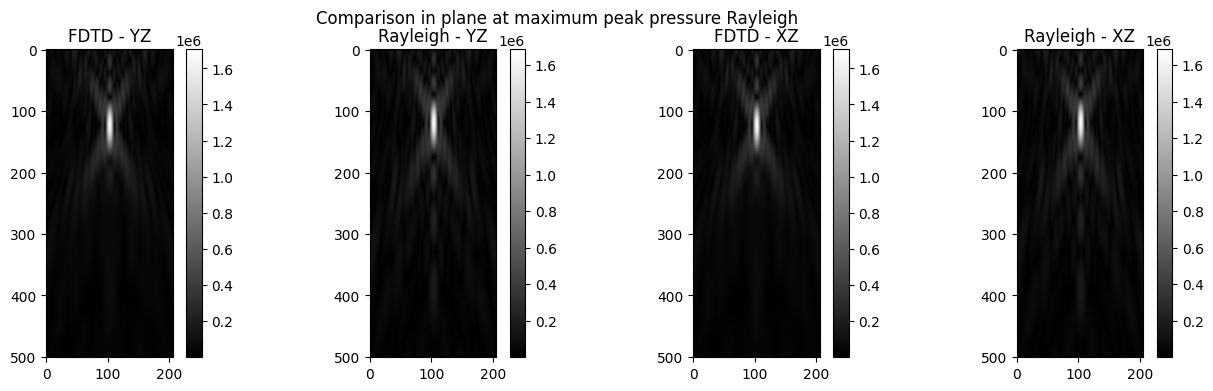

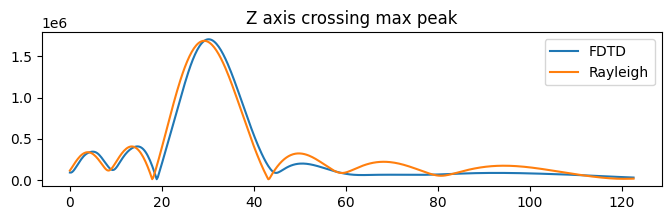

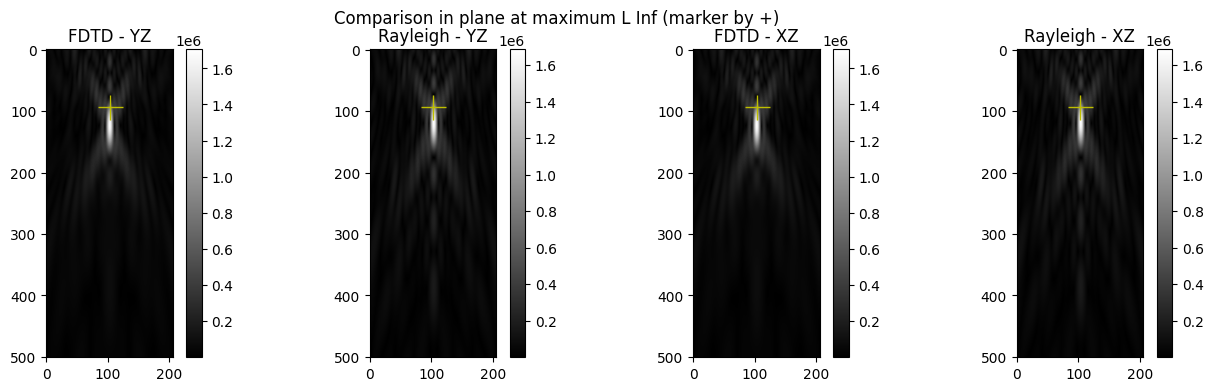

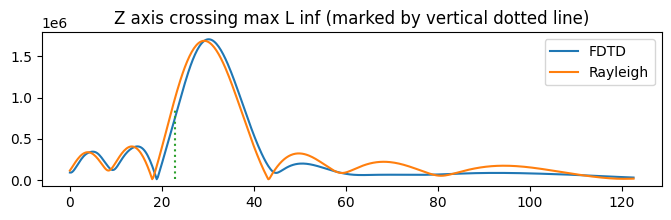

In [83]:
CASE=225;FDTD=glob(BasePath+'CASE_%04i_FDTD*' % CASE )[0];Ray=glob(BasePath+'CASE_%04i_Rayleigh*' % CASE)[0]
print(os.path.basename(FDTD))
qcheck(FDTD,Ray,bPlot=True)

CASE_0193_FDTD_ConeDistance_30.0_DEEP_H317_250kHz_9PPW_XSteer_0.0_YSteer_0.0_ZSteer_0.0.nii.gz
Length 6dB  in mm, limits and peak location=40.657,9.127,49.784,25.990



{'Distance focal centroid': 0.4246525040435394,
 'Distance focal max': 0.4899899959564209,
 'Difference amplitude': 2.63353346940995,
 'Difference volume': -12.476180924681577,
 'Difference acoustic long axis': -9.707594168399558,
 'Difference acoustic width 1': -1.6016583262563344,
 'Difference acoustic width 2': -1.6016583262563344,
 'L Inf': 13.525576680201382,
 'L Inf location': [51, 51, 162],
 'L2': 15.727482083742997}

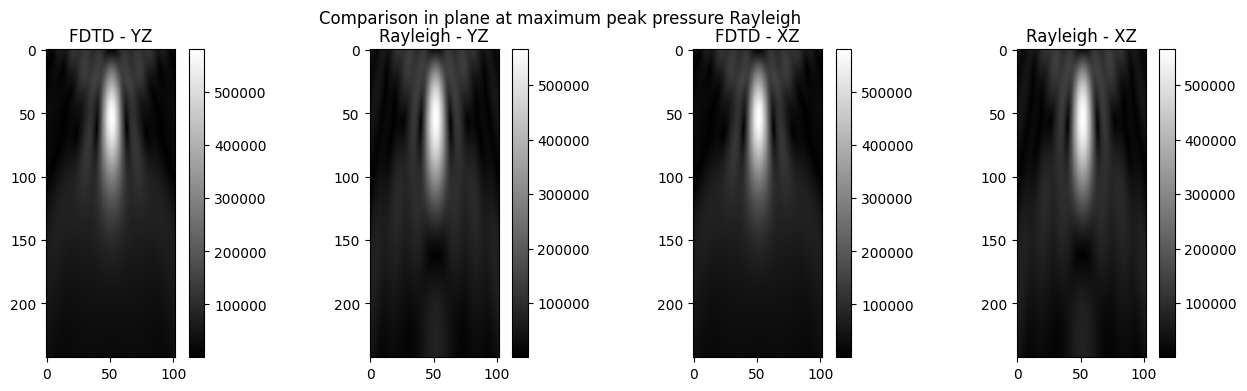

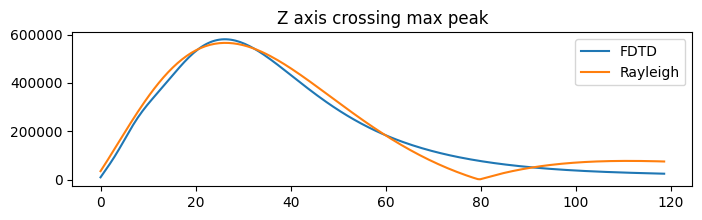

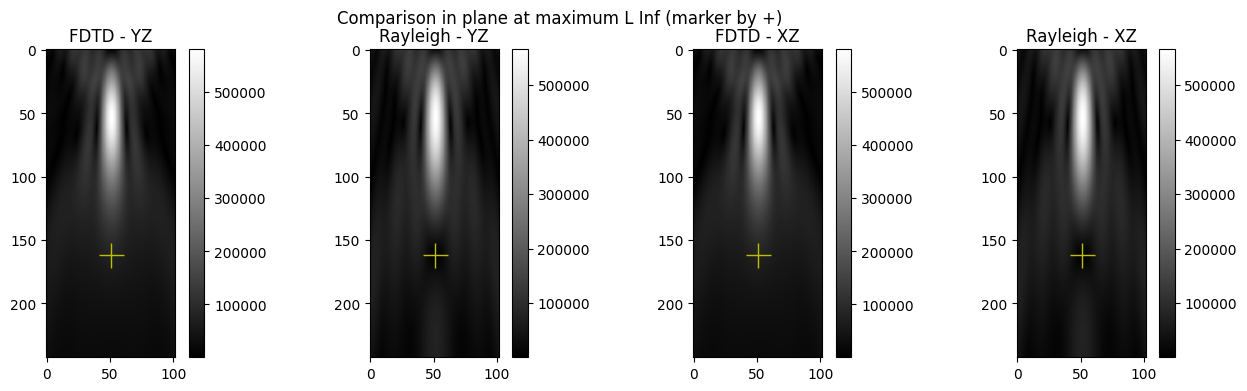

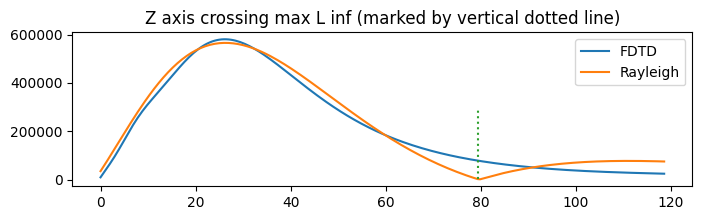

In [84]:
CASE=193;FDTD=glob(BasePath+'CASE_%04i_FDTD*' % CASE )[0];Ray=glob(BasePath+'CASE_%04i_Rayleigh*' % CASE)[0]
print(os.path.basename(FDTD))
qcheck(FDTD,Ray,bPlot=True)